In [1]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score

In [2]:
no_clusters = 100

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
batch1 = unpickle('./cifar/data_batch_1')
batch2 = unpickle('./cifar/data_batch_2')
batch3 = unpickle('./cifar/data_batch_3')
batch4 = unpickle('./cifar/data_batch_4')
batch5 = unpickle('./cifar/data_batch_5')
batch6 = unpickle('./cifar/test_batch')

In [ ]:
def prepareDataset(dataset):
    trainLabels=[]
    trainImg = dataset[b'data'].reshape(len(dataset[b'data']),3,32,32).transpose(0,2,3,1)
    for i in dataset[b'labels']:
        trainLabels.append(i)
    return trainImg, trainLabels


In [ ]:
trainImg1,trainLabel1 = prepareDataset(batch1)
trainImg2,trainLabel2 = prepareDataset(batch2)
trainImg3,trainLabel3 = prepareDataset(batch3)
trainImg4,trainLabel4 = prepareDataset(batch4)
trainImg5,trainLabel5 = prepareDataset(batch5)
testImgs,testLabels = prepareDataset(batch6)



In [ ]:
trainImgs = np.concatenate((trainImg1,trainImg2,trainImg3,trainImg4,trainImg5), axis=0)

In [ ]:
trainLabels = np.concatenate((trainLabel1, trainLabel2, trainLabel3,trainLabel4,trainLabel5),axis=0)

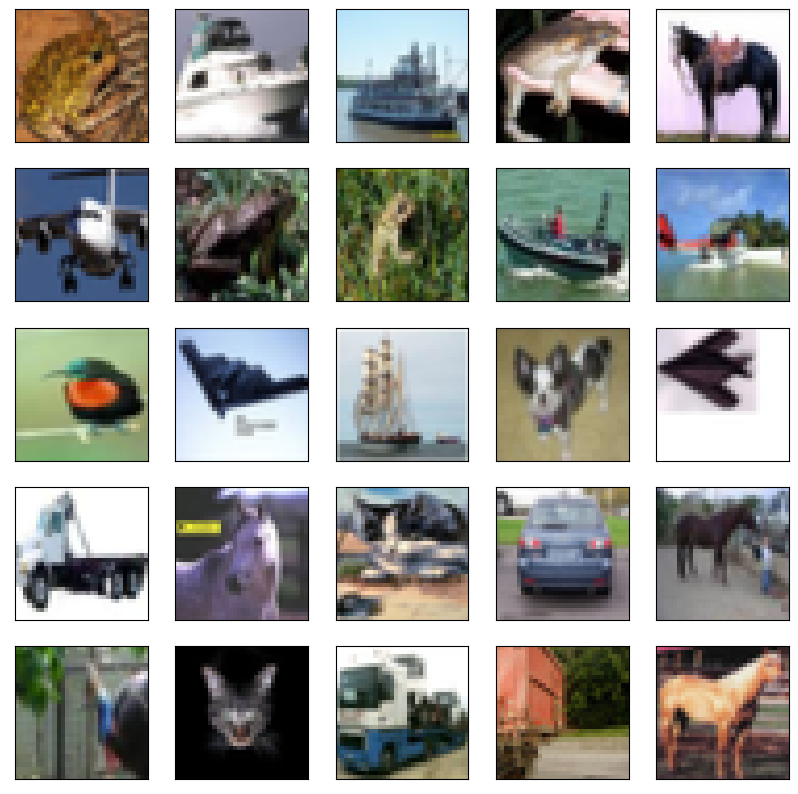

In [ ]:
import numpy as np
# take the images data from batch data
images = batch1[b'data']
# reshape and transpose the images
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
# take labels of the images 
labels = batch1[b'labels']


# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
def getDescriptors(sift, img):#Extracting the interest points and descriptors of images
    kp, des = sift.detectAndCompute(img, None)
    return des

In [ ]:
def extract(imgs): #Extracting all the descriptors of images
    desc_list = []
    count = 0
    index = 0
    index_list = []
    sift = cv2.SIFT_create()
    for img in imgs:
        desc = getDescriptors(sift,img)
        if(desc is not None):
            count = count+1
            desc_list.append(desc)
        else:
            index_list.append(index)
        index = index+1


    return desc_list,count,index_list

In [ ]:
def deleteIndex(trainImgs,trainLabels,index_list): #Deleting those labels and points which dont have descriptors
    trainLabels=np.delete(trainLabels,index_list)
    trainImgs=np.delete(trainImgs, index_list)
    return trainImgs, trainLabels

In [ ]:
def vstackDescriptors(descriptor_list):#Reorganizing the descriptor list
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors



In [ ]:
def clusterDescriptors(descriptors, no_clusters): #Applying K means on all the descriptors
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

In [ ]:
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters): # Creating histograms which will be used as features in the ML model
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

In [ ]:
def normalizeFeatures(scale, features): # Normalizing the features
    return scale.transform(features)

In [ ]:
desc_list,count,index_list=extract(trainImgs)


In [ ]:
trainImgs,trainLabels = deleteIndex(trainImgs, trainLabels,index_list)

In [ ]:
descriptors = vstackDescriptors(desc_list)


In [ ]:
kmeans = clusterDescriptors(descriptors, no_clusters=no_clusters)

In [ ]:
im_features= extractFeatures(kmeans, desc_list, count, no_clusters=no_clusters)

In [ ]:
scale = StandardScaler().fit(im_features)    
im_features = scale.transform(im_features)

In [ ]:
desc_list,count,index_list=extract(testImgs)

In [ ]:
testImgs,testLabels = deleteIndex(testImgs, testLabels,index_list)

In [ ]:
descriptors = vstackDescriptors(desc_list)

In [ ]:
test_features = extractFeatures(kmeans, desc_list, count, no_clusters=no_clusters)
test_features = scale.transform(test_features)

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear').fit(im_features, trainLabels)


In [ ]:
pred=lm.predict(test_features)
len(pred)
accuracy_score(pred, testLabels)


0.27415797914995993